# Reinforcement Learning
## Best√§rkendes Lernen
<img width=800 height=800 class="imgright" src="Images/robot.png">

Best√§rkendes Lernen (Reinforcement Learning) ist eine Methode des ML wo ein sog. Lernagent mit seiner Umwelt interagiert, diese beobachten und interpretieren kann. Der Agent lernt durch "Versuch und Irrtum" bei seinen Aktionen und wird je nach dem Erfolg der jeweiligen Aktion belohnt oder bestraft durch die Anwendung einer Belohnungsfunktion. Es ist eine Methode mit potenziell grossem Anwendungsbereich und wird in einer Vielzahl von Disziplinen wie Spieltheorie, Kontrolltheorie, Simulationsoptimierung, Schwarmintelligenz... verwendet. Auch beim autonomen Autofahren ist es im Einsatz. Man sucht damit oft optimale L√∂sungen f√ºr Kontrollalgorithmen. <br>
Es handelt sich insgesamt um einen Markov-Prozess mit schrittweisen √Ñnderungen eines Systems, bei dem die Wahrscheinlichkeit der √Ñnderung eines Systemzustandes beim Schritt x nur vom vorherigen Zustand des Systems beim Schritt x-1 abh√§ngt.
<img width=1000 height=800 class="imgright" src="Images/ReinforcementLearning.png"><br><br>


Wir zeigen jetzt das Prinzip am Beispiel eines Agenten, der das Spiel Tic Tac Toe lernen soll. <br>
<img width=500 height=500 class="imgright" src="Images/TicTacToe.png"><br><br>


Hierzu schreiben wir ein kleines Script, welches eine grosse Anzahl (bis mehrere Millionen) von TicTacToe Partien spielt, wobei beide Spieler vom Computer gestellt werden und die Spielz√ºge zuf√§llig erfolgen. 

Das Spielbrett wird durch eine Liste von Listen (board) dargestellt. Besetzte Felder haben entweder den Eintrag 1 f√ºr den einen Spieler oder 2 f√ºr den Gegner. Freie Felder haben den Eintrag 0.  Unten ein Beispiel.

In [1]:
board=[[0,1,0],[0,2,0],[1,0,0]]
[print(row) for row in board] #Beispiel Brett
print("")

[0, 1, 0]
[0, 2, 0]
[1, 0, 0]



Wir ben√∂tigen nun den ```Aktionsspace```, der die m√∂glichen Aktionen des (der) Agenten im Spiel darstellt. Er umfa√üt hier nur:
Spieler 1 setzt oder Spieler 2 setzt. Im Programm mu√ü nat√ºrlich gepr√ºft werden, ob die entsprechende Aktion auch erlaubt ist (Zug auf ein leeres Feld, abwechselndes Ziehen).
Sodann bauen wir den ```Statusspace``` auf. Hier werden alle m√∂glichen Zust√§nde der Umwelt dargestellt. An jeder Stelle des Brettes kann eine 0, eine 1 oder eine 2 stehen. Wir haben so $3^9$ m√∂gliche Brettkonfigurationen. Von diesen sind aber nur die erlaubt,
- die n Einheiten vom Agenten 1 und n+1 Einheiten vom Agenten 2 enthalten oder 
- n Einheiten vom Agenten 1 und n-1 Einheiten vom Agenten 2 <br>
da ja abwechselnd gezogen wird.
In der Funktion make_state_space wird der Statusspace (state_space Dict) nur mit diesen erlaubten Eintr√§gen belegt. 
Wir brauchen dann noch eine Transitionsmatrix weight_dict, diese enth√§lt f√ºr den √úbergang eines Status in den n√§chsten nach einem Zug ein Gewicht. Dieses soll ausdr√ºcken, ob es sich um einen positiv zu bewertenden oder negativ zu berwertenden Zug handelt. 
Beginnen wir jetzt abwechselnd die Agenten 1 und 2 ziehen zu lassen, ist erst beim Ende des Spiels, also wenn ein Agent gewonnen hat, die Bewertung aller Z√ºge m√∂glich. Der Gewinnstatus wird mit der Funktion win() √ºberpr√ºft, die 0 bei Unentschieden, oder jeweils 1 und 2 f√ºr den Gewinner ausgibt. Das Spiel wird nach Gewinn nat√ºrlich abgebrochen. Die Beurteilung der Einzel-Aktionen gelingt nur zeitversetzt. Dies stellt beim Reinforcement Lernen ein h√§ufiges Problem dar. Wir m√ºssen also den Ablauf des Spiels speichern. Dann werden in set_weights() die Gewichte f√ºr die Transitionen angepasst. Die Transitionen des Verlierers werden negativ bewertet, die des Gewinners positv. Die Bewertung erfolgt vom Betrag her umso gr√∂√üer, je mehr Z√ºge schon vergangen sind bis zum Ende des Spiels. Z√ºge am Anfang h√§ngen ja nicht so sehr mit dem Ergebnis zusammen wie die letzten Z√ºge.
Nach vielen Spielen haben so die Gewichte der Transitionen mehr oder weniger hohe positive oder negative Werte erhalten. Wir erhalten ca. 7500 m√∂gliche √úberg√§nge eines erlaubten Brettstatus in einen anderen.
<br>
Dieses weight_dict Dictionary stellt das Ergebnis unserer vielen Spiele dar, es speichert die gesamte Spielerfahrung.<br>
Im Hauptprogramm lassen wir die Spieler abwechseln ziehen (der Anfangsspieler wird zuf√§llig bestimmt).<br> Alle Z√ºge jedes einzelnen Spieles werden in der play_liste festgehalten. Ist das Spiel beendet, werden die Gewichte in weight_dict entsprechend des Ergebnisses und des Ablaufs angepasst.<br>
Am Ende wird dann das gesamte weight_dict Dictionary mit dem pickle Modul gespeichert.


In [6]:
from collections import deque
import random,copy,itertools,sys
actions=[1,2]
random.seed(2)
random.shuffle(actions)
action_space=deque(actions)
#print(action_space)
positions=["*","X","O"]
board=[[0 for _ in range(3)] for _1 in range(3)]
state_space={}
weight_dict={}

learning_steps=2000000 #zwei Millionen Spiele
learning_rate=1

def win(board):    
    for row in board: #Spieler gewinnt eine Reihe    
        if row.count(1)==3:
            return 1
        elif row.count(2)==3:
            return 2
        
    for row in zip(*board[::-1]): #Spieler gewinnt eine Spalte, Board wird 90 Grad gedreht, Reihe wird zu Spalte und vice versa
        if row.count(1)==3:
            return 1
        elif row.count(2)==3:
            return 2
        
    mysum1,mysum2=[],[]
    for x in range(3):
        mysum1.append(board[x][x]) #Spieler gewinnt eine Diagonale oder darunter die andere
        mysum2.append(board[x][2-x])
        if mysum2.count(1)==3 or mysum1.count(1)==3:
            return 1
        elif mysum2.count(2)==3 or mysum1.count(2)==3:
            return 2
 
    return 0


def printb(board):
    for row in range(3):
        print()
        for col in range(3):
            print(positions[board[row][col]],end="")
    return
            
def state_from_board(board):
    newlist = list(itertools.chain(*board))
    num=0
    for _ in range(9):
        num+=newlist[_]*3**_
    return num

def board_from_state(state):
    board_list=[]
    for _ in range(9):
        board_list.append(state%3)
        state=state//3
    board=[]
    board.append(board_list[:3])
    board.append(board_list[3:6])
    board.append(board_list[6:])
    return board
    

def make_state_space():
    state_space={}
    for _ in range(3**9-1):
        key=board_list_to_tuple(board_from_state(_))
        ones,twos=0,0
        for row in board:
            ones+=row.count(1)
            twos+=row.count(2)
        if abs(ones-twos)==1:   
            state_space[key]=_
    return state_space


def board_list_to_tuple(board):
    tup_board=tuple()
    for row in board:
        tup_board+=(tuple(row),)
    return tup_board

def set_weights(play_list):
    total_steps=len(play_list)-1
    faktor=deque([1,-1])    
    for index in range(total_steps,-1,-1):       
        if tuple([play_list[index][0],play_list[index][1]]) not in weight_dict:
            weight_dict[tuple([play_list[index][0],play_list[index][1]])]=faktor[0]*index*learning_rate+1
        else:
            weight_dict[tuple([play_list[index][0],play_list[index][1]])]+=faktor[0]*index*learning_rate+1
        faktor.rotate() 
    return
   
            
#Main Programm
state_space=make_state_space()

for _ in range(learning_steps):
    if _ % 10000==0:
        print(_)
    play_list=[]
    board=[[0 for _ in range(3)] for _1 in range(3)]
    for i in range(9):
        player=action_space[0]
        action_space.rotate()
        before=state_from_board(board)
        
        while True:
            
            row,col=random.randint(0,2),random.randint(0,2)
            if board[row][col]==0:
                board[row][col]=player
                break
        
        
        play_list.append([before,state_from_board(board)])
        
        #print(win(board)) #1 => X 2 => O
        if win(board)!=0:
            set_weights(play_list)
            break
        
print(weight_dict) 
print(len(weight_dict))
name=input("wie soll die Datei mit dem weight_dict heissen?")           
import pickle 
with open(name+".p","wb") as f:
    fboards=pickle.Pickler(f)
    fboards.dump(weight_dict) 

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000
410000
420000
430000
440000
450000
460000
470000
480000
490000
500000
510000
520000
530000
540000
550000
560000
570000
580000
590000
600000
610000
620000
630000
640000
650000
660000
670000
680000
690000
700000
710000
720000
730000
740000
750000
760000
770000
780000
790000
800000
810000
820000
830000
840000
850000
860000
870000
880000
890000
900000
910000
920000
930000
940000
950000
960000
970000
980000
990000
1000000
1010000
1020000
1030000
1040000
1050000
1060000
1070000
1080000
1090000
1100000
1110000
1120000
1130000
1140000
1150000
1160000
1170000
1180000
1190000
1200000
1210000
1220000
1230000
1240000
1250000
1260000
1270000
1280000
1290000
1300000
1310000
1320000
1330000
1340000
1350000
1360000
1370000
1380000
13

wie soll die Datei mit dem weight_dict heissen? weights2mill


Nachdem der oben beschriebene Prozess die Lernphase darstellt, k√∂nnen wir jetzt die Performance des Reinforcement Learning beurteilen, indem wir einen Agenten, der unser weight_dict f√ºr seine Z√ºge verwendet gegen einen Gegner spielen lassen, dessen Z√ºge zuf√§llig erfolgen. Im folgenden Script haben wir ein weight_dict verwendet, da√ü die Ergebnisse von 2.000.000 Spielen enth√§lt. Es werden dann im Duell "trainierter Agent" gegen Zufallsgegner 2000 Partien gespielt und dann das Ergebnis ausgegeben. 0 bedeutet dabei unentschieden, 1 Zufallsgegner gewinnt, 2 trainierter Agent gewinnt. Ein typisches Ergebnis w√§re:<br>{0: 42, 1: 64, 2: 1868}<br>
Der trainierte Agent nimmt f√ºr jeden seiner Z√ºge die Transition, deren weight_dict - Eintrag den h√∂chsten Wert hat.

In [7]:
import pickle,random,itertools,sys,copy
from collections import deque 

weight_dict=pickle.load(open("Data/weights2mill.p","rb")) 
actions=[1,2]
positions=["*","X","O"]

def win(board):    
    for row in board: #Spieler gewinnt eine Reihe    
        if row.count(1)==3:
            return 1
        elif row.count(2)==3:
            return 2
        
    for row in zip(*board[::-1]): #Spieler gewinnt eine Spalte, Board wird 90 Grad gedreht, Reihe wird zu Spalte und vice versa
        if row.count(1)==3:
            return 1
        elif row.count(2)==3:
            return 2
        
    mysum1,mysum2=[],[]
    for x in range(3):
        mysum1.append(board[x][x]) #Spieler gewinnt eine Diagonale oder darunter die andere
        mysum2.append(board[x][2-x])
        if mysum2.count(1)==3 or mysum1.count(1)==3:
            return 1
        elif mysum2.count(2)==3 or mysum1.count(2)==3:
            return 2
    return 0


def printb(board):
    for row in range(3):
        print()
        for col in range(3):
            print(positions[board[row][col]],end="")
    return
            
def state_from_board(board):
    newlist = list(itertools.chain(*board))
    num=0
    for _ in range(9):
        num+=newlist[_]*3**_
    return num

def board_from_state(state):
    board_list=[]
    for _ in range(9):
        board_list.append(state%3)
        state=state//3
    board=[]
    board.append(board_list[:3])
    board.append(board_list[3:6])
    board.append(board_list[6:])
    return board
    

def make_state_space():
    state_space={}
    for _ in range(3**9-1):
        key=board_list_to_tuple(board_from_state(_))        
        state_space[key]=_
    return state_space


def board_list_to_tuple(board):
    tup_board=tuple()
    for row in board:
        tup_board+=(tuple(row),)
    return tup_board
   
anzahl_spiele=2000           
win_dict={0:0,1:0,2:0}
state_space=make_state_space()
for _ in range(anzahl_spiele):
    random.shuffle(actions)
    action_space=deque(actions)
    board=[[0 for _ in range(3)] for _1 in range(3)]
    for _ in range(9):
        player=action_space[0] 
        #SPIELER 1
        if player==1:            
            while True: 
                row,col=random.randint(0,2),random.randint(0,2)
                if board[row][col]==0:
                    board[row][col]=player
                    action_space.rotate()
                    #printb(board)
                    break
            if win(board)==1:
                #printb(board)
                win_dict[1]+=1
                break
            continue
        #ENDE SPIELER 1
        #SPIELER 2
        zug_list=[]
        for row in range(3):
            for col in range(3):
                if board[row][col]==0:
                    zug_list.append([row,col])
        poss_dict=dict()        
        for zug in zug_list:
            temp_board=copy.deepcopy(board)
            temp_board[zug[0]][zug[1]]=2
            now,then=state_from_board(board),state_from_board(temp_board)            
            if (now,then) in weight_dict.keys():                
                poss_dict[then]=weight_dict[(now,then)]
            else:
                poss_dict[then]=0
        
        max_zug=max(poss_dict.values())        
        zug=[key for key,val in poss_dict.items() if val==max_zug][0]        
        board=board_from_state(zug)
        #printb(board)        
        if win(board)==2:
            #printb(board)
            win_dict[2]+=1
            break
        action_space.rotate()
        

win_dict[0]=anzahl_spiele-win_dict[1]-win_dict[2]                
print(win_dict)

{0: 62, 1: 43, 2: 1895}


Hier eine Grafik, die die Performance in Abh√§ngigkeit von der Zahl der Trainingsspiele zeigt.<br>
<img width=700 src="Images/performance.png" >

Wir sehen, da√ü nach ausreichend Training der Zufallsgegner kaum mehr eine Chance hat.<br>
Der Agent ist noch nicht perfekt, aber schon erstaunlich gut. Obwohl wir so nur ein einfaches Spiel mit Reinforcement Lernen trainiert haben, zeigt sich doch die Leistungsf√§higkeit des Verfahrens. Best√§rkendes Lernen ist vor allem in der Robotik ein nicht mehr wegzudenkendes ML Verfahren. Man erkennt auch, wenn man reflektiert, wie man selbst Tic Tac Toe "gelernt hat zu spielen", dass ML hier einen v√∂llig anderen Ansatz verfolgt. Es werden keine Regeln gelernt, wie z.B.: Wenn der Gegner 2 Steine in einer Reihe oder Spalte oder Diagonale hat, und die dritte Stelle f√ºr seinen Gewinn frei ist, muss man in n√§chsten Zug diesen Platz durch einen eigenen Stein unbedingt blockieren o.√§.. So lernt dieses Programm nicht. Es spielt "blind" gen√ºgend Partien und lernt dadurch ganz allgemein gute Antwortz√ºge. Wollte man jetzt den Agenten noch besser machen, m√ºsste man einen Agenten_Version 2 gegen den jetzigen Agenten spielen lassen. Bei diesem besseren Gegner w√ºrde dann der neue Agent auch besser lernen.Hier noch einmal schematisch der Ablauf.

<img width= 600 src="Images/ReinforcementModell1.png">

<img width=700 src="Images/ReinforcementModell2.png" >

Ein kleiner Nebenschauplatz:<br><br>Hier zeigen wir als Nebeninformation eine elegante Methode, um ein Koordinatensystem, welches aus Listen von Listen besteht (wie in unserem Fall das Board) um 90 Grad zu drehen. Die erleichtert sehr das Pr√ºfen von Columns.

In [2]:
################NEBENBEMERKUNG######################

#Drehung 90 im Uhrzeigersinn
def print_board(board):    
    for row in board:
        for elem in row:
            #print(elem,end=" ")
            print(elem,end=" ")
        print()
    print(15*"-"+"\n")
    
board0=[[1,2,3],[4,5,6],[7,8,9]]
#print(*board0)
#print(*board0[::-1])
#print(list(zip(*board0)))
print_board(board0)
board=list(zip(*board0[::-1])) #!!!!!90 Grad
print_board(board)
board=list(zip(*board0))#diagonal getauscht
print_board(board)

1 2 3 
4 5 6 
7 8 9 
---------------

7 4 1 
8 5 2 
9 6 3 
---------------

1 4 7 
2 5 8 
3 6 9 
---------------



Alternativ k√∂nnte man alle Zugm√∂glichkeiten durchspielen, wie f√ºr den ersten Zug im nachfolgenden Beispiel gezeigt.

In [3]:
import random
def print_it(board):
    for row in board:
        for elem in row:
            if elem==-1:
                print("X",end="")
            elif elem==1:
                print("0",end="")
            else:
                print(".",end="")
        print()
    return

def test_for_win(board):
    for row in board:
        if abs(sum(row))==3:            
            return True
    for row in zip(*board[::-1]):        
        if abs(sum(row))==3:            
            return True
    dig1,dig2=0,0
    for _ in range(3):
        dig1+=board[_][_]
        dig2+=board[_][2-_]
    if abs(dig1)==3 or abs(dig2)==3:        
        return True
    return False
        
def ziehen(who,board,zugliste,zug):
    #print(who,board,zugliste,zug)
    
    global resultlist
    zug+=1
    l=[]
    for row in range(3):
        for col in range(3):
            if board[row][col]==0:
                l.append((row,col))
    x,y=random.choice(l) #compare here
    board[x][y]=1 if who=="Comp1" else -1
    zugliste.append((x,y))
    if test_for_win(board)==True:       
        #print(f"{who} wins")
        resultlist[0 if who=="Comp1" else 1]+=1
        #print(zugliste)
        #print()
        #print_it(board)
        return False,False,False
    if zug==9:
        #print("Draw")
        resultlist[2]+=1
        #print(zugliste)
        #print()
        #print_it(board)
        return False,False,False
    return board,zugliste,zug
def init_zug(board,zug):
    #mache init zug
    x,y=zug
    zugliste.append((x,y))
    
    board[x][y]=1 
    return board,zugliste
    

init_liste=[(0,0),(0,1),(0,2),(1,0),(1,1),(1,2),(2,0),(2,1),(2,2)] 
for init in init_liste:
    resultlist=[0,0,0]
    for _ in range(10000):        
        #if _%1000==0:print(_)
        board=[[0,0,0],[0,0,0],[0,0,0]]
        who_draws="Comp1"
        zugliste=[]
        
        board,zugliste=init_zug(board,init)
        
        #print(board,zugliste)
    
        who_draws,zug="Comp2",1
        for __ in range(8):
            board,zugliste,zug=ziehen(who_draws,board,zugliste,zug)
            if board==False:# draw or win      
                break
            if who_draws=="Comp1":
                who_draws="Comp2"
            else:
                who_draws="Comp1"
    print(f" f√ºr Anfangszug {init} gewinnt der Agent bei 10000 Spielen {resultlist[0]} mal, er verliert {resultlist[1]} mal, Unentschieden {resultlist[2]} mal")

 f√ºr Anfangszug (0, 0) gewinnt der Agent bei 10000 Spielen 6023 mal, er verliert 2642 mal, Unentschieden 1335 mal
 f√ºr Anfangszug (0, 1) gewinnt der Agent bei 10000 Spielen 5359 mal, er verliert 3348 mal, Unentschieden 1293 mal
 f√ºr Anfangszug (0, 2) gewinnt der Agent bei 10000 Spielen 6148 mal, er verliert 2626 mal, Unentschieden 1226 mal
 f√ºr Anfangszug (1, 0) gewinnt der Agent bei 10000 Spielen 5387 mal, er verliert 3326 mal, Unentschieden 1287 mal
 f√ºr Anfangszug (1, 1) gewinnt der Agent bei 10000 Spielen 6929 mal, er verliert 1859 mal, Unentschieden 1212 mal
 f√ºr Anfangszug (1, 2) gewinnt der Agent bei 10000 Spielen 5370 mal, er verliert 3339 mal, Unentschieden 1291 mal
 f√ºr Anfangszug (2, 0) gewinnt der Agent bei 10000 Spielen 6075 mal, er verliert 2679 mal, Unentschieden 1246 mal
 f√ºr Anfangszug (2, 1) gewinnt der Agent bei 10000 Spielen 5238 mal, er verliert 3474 mal, Unentschieden 1288 mal
 f√ºr Anfangszug (2, 2) gewinnt der Agent bei 10000 Spielen 5984 mal, er verlier

Der beste erste Zug scheint danach 1,1 zu sein. Dies k√∂nnte man f√ºr die Folgez√ºge fortsetzen und erh√§lt dann eine Liste der jeweils optimalen Z√ºge. Dies ist dann ein "Durchrechnen" des gesamten Spielebaums und kein echtes Reinforcement-Lernen. Dieses Verfahren ist nur m√∂glich f√ºr sehr kleine Status-Spaces.

<br><img width=500 src="Images/Taxi.png" ><br><br>Hier haben wir ein zweites Beipiel f√ºr <b>Reinforcement Learning, das Taxi-Beispiel.</b> Wir haben eine Umgebung mit 5 x 5 Feldern.
Darin befindet sich an einer bestimmten Stelle ein Taxi (t). Dieses kann in der Umgebung nach Norden, S√ºden, Westen und Osten fahren, jeweils um einen Schritt. Ein Passagier m√∂chte an einer bestimmten Stelle abgeholt werden und an einer bestimmten Stelle abgesetzt werden. (P und D f√ºr Pickup und Dropoff). In der Umgebung existieren einige Mauern (#) die nicht durchfahren werden k√∂nnen. Unser System soll lernen, den Passagier abzuholen und zum Dropoff zu bringen in m√∂glichst wenig Schritten. Hier die Ausgangsposition unseres Beipiels.

Das Taxi kann jeweils eine Aktion aus den folgenden 6 M√∂glichkeiten durchf√ºhren.

nach Norden ein Feld N
nach S√ºden ein Feld S
nach Westen ein Feld W
nach Osten ein Feld E
Passagier aufnehmen PU
Passagier absetzen DO Dies ist der Aktionspace. Nat√ºrlich kann die Aktion nicht immer durchgef√ºhrt werden, (Mauern, PU wo kein Passagier, Rand erreicht...) F√ºr jeden Schritt mit jeweils einer Aktion gibt es eine Bewertung. In unserem Beispiel kostet jeder Versuch eines Schritts, egal ob er m√∂glich ist oder nicht, einen Minuspunkt. Versuch einen Passagier aufzunehmen, wo keiner ist minus 20 Punkte. Versuch einen Passagier abzusetzen, wenn er gar nicht im Taxi ist oder an der falschen Stelle -20 Punkte. Fahrversuch gegen Mauer oder Rand -10 Punkte. Aufnehmen des Pax an der richtigen Stelle 400 Pluspunkte. Absetzen an der richtigen Stelle 400 Pluspunkte. Diese Werte sind nat√ºrlich willk√ºrlich gew√§hlt, aber spiegeln zumindest im Ansatz den Effekt der Aktion auf das Problem wider. Wir verwenden zum Reinforcement Learning jetzt den Q-Learning Algorithmus. Dazu legen wir zun√§chst unsere Umgebung an (board) mit den Eingangsparametern f√ºr die Position des Taxis, der Pickup und Dropoff Position und den Mauern (make_board()). Dies ist nat√ºrlich nur ein einziger Fall aus einer Menge von m√∂glichen Aufgaben in dieser Umwelt.
Als n√§chstes brauchen wir eine Aktions-Liste, diese ist einfach: ["S","N","E","W","DO","PU"] (wie oben erkl√§rt).
Wir definieren dann f√ºr jede Umweltsituation einen Status, dieser besteht aus der Position des Taxis (Reihe,Spalte) und der Information, ob der Passagier noch am Aufnahmepunkt steht (4,0), oder schon im Taxi sitzt "tax".
Hier das Dict:

Wir haben also 50 m√∂gliche Umweltsituationen, die hier erfasst sind anhand des Values des State-Dicts. Nun brauchne wir  noch ein Reward-Dict, dieses enth√§lt f√ºr jeden Status und f√ºr jede der 6 m√∂glichen Aktionen in dem Status jeweils 3 Informationen. Der Key des Dicts ist der die Statusnummer (s.o.). F√ºr jede Aktion in diesem Status findet sich dann als Eintrag in einem Tupel:
- der Status, der durch die entsprechende Aktion erreicht wird als Statusnummer
- die Bewertung in Anzahl Punkten f√ºr diesen Schritt
- ist das Problem gel√∂st mit dieser Aktion (Bool).
Hier ein Ausschnitt:

Die Erzeugerfunktion make_reward_dict() ber√ºcksichtigt dabei auch, ob die entsprechende Aktion m√∂glich ist, auch bei Vergabe der Bewertung. Versucht das Taxi an seiner Position durch eine Wand zu fahren, bleibt der Status bestehen und die Strafpunkte werden entsprechend eingetragen.Ein Beispiel:
Im Fall Status 0 steht das Taxi bei 0,0 (Status-Dict (0, 0, (4, 0)): 0)). Es kann nicht nach Norden oder Westen, deshalb bleibt bei diesen Aktionen die Statusnummer unver√§ndert, es gibt aber 10 Strafpunkte (5 wie f√ºr jeden Schritt und 5 f√ºr den Versuch einen Wand zu durchfahren). Versucht das Taxi beim Satuts 0 einen Passagier abzusetzen, bleibt die Statusnummer ebenfalls und es gibt 25 Minuspunkte, aus dem Status-Dict f√ºr den Status 0 (0, 0, (4, 0)): 0) ist ja zu sehen, da√ü der Passagier noch auf dem Ausgangspunkt (4,0) steht, Absetzen also nicht m√∂glich ist.
Als letztes brauchen wir jetzt noch ein Q-Dict, welches j√ºr jede Statusnummer 6 Eintr√§ge f√ºr die m√∂glichen Aktionen enth√§lt, die die Gewichte f√ºr die jeweilige Aktion angeben. Diese Gewichte werden zu Beginn der Berechnung alle auf 0 gesetzt, √§ndern sich dann nach jedem Lernschritt. Ein Ausschnitt:

In [ ]:
q_dict={} 
for _ in range(5):
    q_dict[_]={"DO":0,"E":0,"N":0,"PU":0,"S":0,"W":0}
    print(f"Statusnummer {_} {q_dict[_]}")

Jetzt haben wir alle Zutaten f√ºr das Q-Learning. Der Ablauf ist dann folgender:
Nehmen wir an, das System ist im Status 32 (dies entspricht unserer Ausgangssituation (3,1,(4,0)) (Taxi auf 3,1 Passagier auf (4,0). Wir machen jetzt

entweder eine Zufallsauswahl aus unserer Aktionsliste (dies dann, wenn eine Zufallszahl zwischen 0 und 1 kleiner ist als der Hyperparameter epsilon (zwischen 0 und 1).
oder machen die Aktion, die im entsprechenden Eintrag im Q-Dict (status,aktion) das gr√∂√üte Gewicht hat.
Ersterer Fall erlaubt auch suboptimale Aktionen von Zeit zu Zeit auszuprobieren, um nicht v√∂llig dem Overfitting einer zuf√§lligen spezifischen Auswahl zu erliegen.
Der zweite Fall ist einfach die Wahl des Optimums f√ºr diesen Status.
Jetzt wird unser Q-Dict upgedatet nach folgender Formel:

$$ùëÑùê∑ùëñùëêùë°ùë¢ùëùùëëùëéùë°ùëíùëë(ùëÜùë°ùëéùë°ùë¢ùë†,ùê¥ùëòùë°ùëñùëúùëõ)=(1‚àíùëéùëôùëù‚Ñéùëé)‚àóùëÑùëëùëñùëêùë°(ùëÜùë°ùëéùë°ùë¢ùë†,ùê¥ùëòùë°ùëñùëúùëõ)+ùëîùëéùëöùëöùëé(ùëÄùëéùë•ùëñùëöùë¢ùëö(ùëÑùëëùëñùëêùë°(ùëõ√§ùëê‚Ñéùë†ùë°ùëíùëüùëÜùë°ùëéùë°ùë¢ùë†,ùëéùëôùëôùëíùê¥ùëòùë°ùëñùëúùëõùëíùëõ))$$

Dies stellt den Q-learning Algorithmus dar. Wir erkennen alpha und gamma als zus√§tzliche Hyperparameter (0-1).
alpha steht f√ºr die Gr√∂√üe jedes Upate-Schrittes. Im ersten Teil wird einfach der Wert des momentanen Qdict-Eintrages entsprechend des Status und der Aktion mit alpha multipliziert. Dies stellt den jetzigen Status dar.
gamma k√ºmmert sich dann um die Bewertung des Status nach dem Durchf√ºhren der Aktion. Alle Aktionen im diesem n√§chsten Status werden gepr√ºft im Qdict und die Aktion mit dem h√∂chsten Gewicht gew√§hlt und mit gamma multipliziert.
alpha k√ºmmert sich also um die generelle Updategr√∂√üe und gamma um die Ber√ºcksichtigung des Optimums im Qdict f√ºr den n√§chsten Status und alle daraus m√∂glichen Aktionen, damit um die Ber√ºcksichtigung der Zukunft unseres momentanen Schrittes.
Es empfiehlt sich alle 3 Hyperparameter im Lauf der Durchl√§ufe zu verkleinern, alpha soll immer kleinere Lernschritte erm√∂glichen, gamma soll, wenn wir nahe dem Ziel sind, nicht mehr sosehr den m√∂glichen n√§chsten Schritt betonen und epsilon soll immer weniger Zufallselemente einbringen. Wir machen eine Anzahl von Durchg√§ngen (z.B.: trials=100000). In jedem Durchgang wird die Umgebung auf den Ausgangswert zur√ºckgesetzt und das QDict weiterbearbeitet. Der Duchgang bricht ab, wenn erfolgreich der Passagier abgesetzt wurde oder nach sp√§testens 100 Schritten.<br><br> Hier also unsere Hyperparameter:<br><br>
alpha0=.05 #update size<br>
gamma0=.8 #future effect<br>
epsilon0=.1 #random choice effect <br>F√ºr jeden Durchgang speichern wir die Abfolge der Aktionen sowie die Summe der Punkte, die sich durch die Aktionen ergeben.
Der k√ºrzeste denkbare Weg w√§re :<br>
N W S S PU N N E E E E S S DO.<br>
Also 14 Schritte. Dies zur Beurteilung des Lernerfolges.

Lassen wir unser Q_Learning laufen mit den genannten Hyperparametern. (Dies braucht einen kleinen Moment).

+#########+
# : # : : #
# : : : : #
# : : : : #
# #t: # : #
#P# : # :D#
+#########+
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
ACTIONS ('N', 'W', 'S', 'S', 'PU', 'N', 'N', 'E', 'E', 'E', 'S', 'S', 'E', 'DO')  L√§nge:  14
Punkte 730


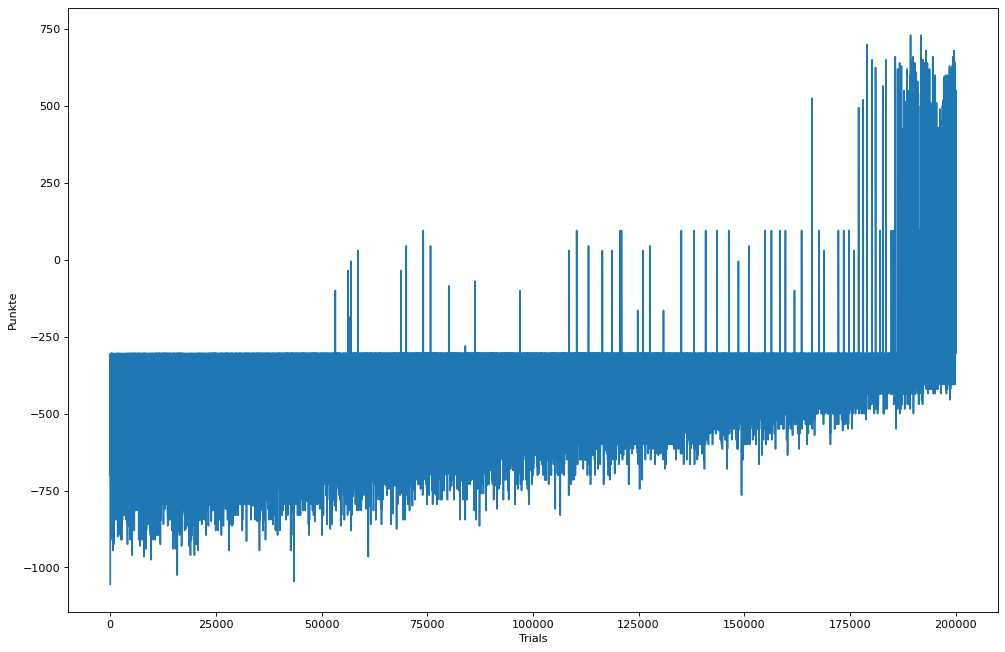

In [4]:
import random,time,sys,pprint,matplotlib.pyplot as plt
random.seed(1007)
def print_board(board):
    print("+#########+")
    for y in range(5):
        print("#",end="")
        for x in range(5):
            
            print(board[y][x],end="")
            print("#" if (y,x) in obstac else":" if x !=4 else "#",end="")
        print()
    print("+#########+")
    return


def make_board(tax_pos,pick_up,drop_off):
    board=[[" " for x in range(5)] for y in range(5)]
    board[drop_off[0]][drop_off[1]]="D"
    board[pick_up[0]][pick_up[1]]="P"
    board[tax_pos[0]][tax_pos[1]]="t"
    return board


def get_state(tax_row,tax_col,pass_pos):
    for key,val in state_dict.items():
        if key==(tax_row,tax_col,pass_pos):
            state=val
            break
    else:
        print("found no state")
    return state

def make_reward_dict(board):
    #reward_dict={}
    reward_wall=50 #Bestrafung f√ºr Wandkontakt
    for state,nr in state_dict.items():
        #print(nr)
        ystate,xstate,pass_pos=state
        inner_dict={}
        for action in ["S","N","E","W","DO","PU"]:
            reward=0
            if action=="S":
                reward=-5
                new_y=ystate+1
                new_x=xstate
                if ystate==4:
                    reward-=reward_wall
                    new_y=ystate
                
                new_state=get_state(new_y,new_x,pass_pos)
                inner_dict["S"]=(new_state,reward,False)
            if action=="N":
                reward=-5
                new_y=ystate-1
                new_x=xstate
                if ystate==0:
                    reward-=reward_wall
                    new_y=ystate
                
                new_state=get_state(new_y,new_x,pass_pos)
                inner_dict["N"]=(new_state,reward,False)
                    
            if action=="E":
                reward=-5
                new_y=ystate
                new_x=xstate+1
                if xstate==4 or (ystate,xstate) in obstac:
                    reward-=reward_wall
                    new_x=xstate
                
                new_state=get_state(new_y,new_x,pass_pos)
                inner_dict["E"]=(new_state,reward,False)
                
            if action=="W":
                reward=-5
                new_y=ystate
                new_x=xstate-1
                if xstate==0 or (ystate,xstate-1) in obstac:
                    reward-=reward_wall
                    new_x=xstate
                
                new_state=get_state(new_y,new_x,pass_pos)
                inner_dict["W"]=(new_state,reward,False) 
                
            if action=="DO":
                if pass_pos=="tax" and (ystate,xstate)==drop_off:
                    reward+=395
                    new_state=get_state(ystate,xstate,"tax")
                    inner_dict["DO"]=(new_state,reward,True)
                    
                else:
                    reward-=70
                    new_state=nr
                    inner_dict["DO"]=(new_state,reward,False)
                    
            if action=="PU":
                if pass_pos!="tax" and (ystate,xstate)==pick_up:
                    reward+=395
                    new_state=get_state(ystate,xstate,"tax")
                    inner_dict["PU"]=(new_state,reward,False)
                    
                else:
                    reward-=70
                    new_state=nr
                    inner_dict["PU"]=(new_state,reward,False)
        
        reward_dict[nr]=inner_dict
    
    return reward_dict        


    
tax_pos=(3,1)
obstac=[(0,1),(3,0),(3,2),(4,0),(4,2)]
pick_up=(4,0)
drop_off=(4,4)
state_dict={}
tab1=[pick_up,"tax"]
counter=0
for y in range(5):
    for x in range(5):
        for pos in tab1:            
            state_dict[(y,x,pos)]=counter
            counter+=1
start_state=state_dict[(tax_pos[0],tax_pos[1],pick_up)]



board=make_board(tax_pos,pick_up,drop_off)
print_board(board)

reward_dict={}
reward_dict=make_reward_dict(board)

q_dict={} 
for _ in range(50):
    q_dict[_]={"DO":0,"E":0,"N":0,"PU":0,"S":0,"W":0}
evaluations=[]
action_dict={}
###########################################################
#hyperparameter
trials=200000
alpha0=.2 #update size 0.05
gamma0=.9 #future effect 0.8
epsilon0=.1 #random choice effect
epoch_max=60 #nach wieviel Schritten Versuch abbrechen? 100

############################################################

for _ in range(trials):
    if _%10000==0:
        print(_)
    alpha=alpha0*(1-_/(trials+1))
    gamma=gamma0*(1-_/(trials+1))
    epsilon=epsilon0*(1-_/(trials+1))
    state=start_state    
    epoch,evaluation,done,actions=0,0,False,()
    
    while not done:
        #print(f"Epoch: {epoch}")
        if random.uniform(0,1)<epsilon:
            action=random.choice(["S","N","E","W","DO","PU"])
            
        else:
            val=q_dict[state]
            maxval=max(val.values())
           
            for key,v in val.items():
                if v==maxval:
                    action=key 
                    break
      
        actions+=action,
        q0=q_dict[state][action] #alter wert q
        new_state=reward_dict[state][action][0] #neuer state
        next_max=max([val[0] for val in reward_dict[new_state].values()]) #max_wert in q f√ºr neuen state
        
        done=reward_dict[state][action][2]
        q1=(1-alpha)*q0 + alpha * (reward_dict[state][action][1] + gamma * next_max)
        
        evaluation+=reward_dict[state][action][1]
        
        q_dict[state][action]=q1
        state=new_state
        epoch+=1
        if epoch>epoch_max:
            done=True
    
    action_dict[_]=actions
    evaluations.append(evaluation)
    
plt.figure(figsize = (15, 10), dpi = 80)    
plt.xlabel("Trials") 
plt.ylabel("Punkte")
plt.plot(list(range(trials)),evaluations)
max_eval=max(evaluations)
ind=[index for index in range(len(evaluations)) if evaluations[index]==max_eval]
print("ACTIONS",action_dict[ind[0]]," L√§nge: ",len(action_dict[ind[0]]))
print("Punkte",evaluations[ind[0]])





Wir sehen, da√ü mit den richtigen Hyperparametern alpha, epsilon und gamma, die dynamisch mit der Anzahl der L√§ufe angepasst werden, sehr gute Ergebnisse erreicht werden k√∂nnen. (In unserem Beispiel sogar optimal!) Die optimale L√§nge der Aktionfolge betr√§gt ja -wie oben gezeigt- 14 Schritte. Q-Learning funktioniert also. Alternativ machen wir jetzt einen "brute force" Versuch. Wir fahren einfach zuf√§llig durch unsere Umgebung und nehmen dann das beste Ergebnis. Hier machen wir auch 200000 Durchg√§nge und brechen jeden Durchgang ab, wenn er entweder erfolgreich ist, oder wenn die Aktionszahl 35 √ºberschreitet.

+#########+
# : # : : #
# : : : : #
# : : : : #
# #t: # : #
#P# : # :D#
+#########+
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000


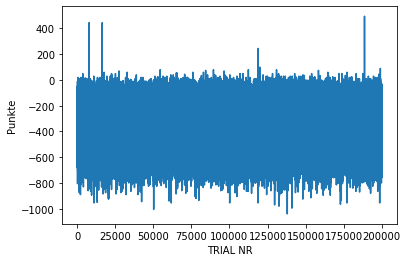

['E', 'W', 'N', 'N', 'S', 'W', 'S', 'S', 'PU', 'N', 'N', 'E', 'E', 'S', 'N', 'E', 'N', 'S', 'E', 'S', 'S', 'DO']  Punkte:  495  L√§nge:  22
+#########+
# : # : : #
# : : : : #
# : : : : #
# #t: # : #
#P# : # :D#
+#########+


In [5]:
import random,time,matplotlib.pyplot as plt
random.seed(1007)
def print_board(board):
    print("+#########+")
    for y in range(5):
        print("#",end="")
        for x in range(5):
            
            print(board[y][x],end="")
            print("#" if (y,x) in obstac else":" if x !=4 else "#",end="")
        print()
    print("+#########+")
    return


def make_board(tax_pos,pick_up,drop_off):
    board=[[" " for x in range(5)] for y in range(5)]
    board[drop_off[0]][drop_off[1]]="D"
    board[pick_up[0]][pick_up[1]]="P"
    board[tax_pos[0]][tax_pos[1]]="t"
    return board


def get_state(tax_row,tax_col,pass_pos):
    for key,val in state_dict.items():
        if key==(tax_row,tax_col,pass_pos):
            state=val
            break
    else:
        print("found no state")
    return state
def state_to_vars(state):
    for key,val in state_dict.items():
        if val==state:
            row,col,pass_pos=key[0],key[1],key[2]
            break
    return row,col,pass_pos

def check_move(state,action):
    global evaluation
    evaluation-=5
    board[drop_off[0]][drop_off[1]]="D"
    board[pick_up[0]][pick_up[1]]="P"
    for key,val in state_dict.items():
        if val==state:
            info=key
            break
    row,col,pass_pos=info[0],info[1],info[2]
    #if (row,col)==(4,0):
        #print("HELLO",pick_up==(row,col),action)
        

    if action=="S" and row==4:
        evaluation-=10
        return False
    elif action=="N" and row==0:
        evaluation-=10
        return False
    elif action=="W" and (col==0 or (row,col-1) in obstac):
        evaluation-=10
        return False
    elif action=="E" and (col==4 or (row,col) in obstac):
        evaluation-=10
        return False
    elif action=="DO" and (pass_pos != "tax" or drop_off !=(row,col)):
        evaluation-=20
        return False
    elif action=="PU" and ((row,col)!=pick_up or pass_pos =="tax"):
        evaluation-=20
        return False
        
    
    return True

#parameter initialisierung
tax_pos=(3,1)
obstac=[(0,1),(3,0),(3,2),(4,0),(4,2)]
pick_up=(4,0)
drop_off=(4,4)
loop_nr=200000
#initialize board
board=make_board(tax_pos,pick_up,drop_off)
print_board(board)

#make state_dict
state_dict={}
tab1=[pick_up,"tax"]

counter=0
for y in range(5):
    for x in range(5):
        for pos in tab1:            
            state_dict[(y,x,pos)]=counter
            counter+=1


#initialize state
state=get_state(tax_pos[0],tax_pos[1],pick_up)


#initialize analysis values
best=-1000
best_way=[]
res=[]
actions=[]
#epoch loop
for _ in range(loop_nr):
    if _%10000==0:
        print(_)
    
    curr_actions=[]
    counter=0
    evaluation=0 
    row=tax_pos[0]
    col=tax_pos[1]
    pass_pos=pick_up
    state=get_state(tax_pos[0],tax_pos[1],pick_up)
    while True:
        
        counter+=1
        
        
        action=random.choice(["S","N","E","W","DO","PU"])
        
        
        if not(check_move(state,action)):
            
            continue
        
        else:
            curr_actions.append(action)
            row,col,pass_pos=state_to_vars(state)
            
            if action=="S":
                board[row][col]=" "
                row+=1
                board[row][col]="t" if pass_pos!="tax" else "T"
                state=state_dict[(row,col,pass_pos)]
            elif action=="N":
                board[row][col]=" "
                row-=1
                board[row][col]="t" if pass_pos!="tax" else "T"
                state=state_dict[(row,col,pass_pos)]
            elif action=="E":
                board[row][col]=" "
                col+=1
                board[row][col]="t" if pass_pos!="tax" else "T"
                state=state_dict[(row,col,pass_pos)]
            elif action=="W":
                board[row][col]=" "
                col-=1
                board[row][col]="t" if pass_pos!="tax" else "T"
                state=state_dict[(row,col,pass_pos)]
            elif action=="DO":
                
                evaluation+=400
                #print("Ergeb: Step Eval",counter,evaluation)
                res.append(evaluation)
                if evaluation>best:
                    actions=curr_actions.copy()
                    best=evaluation
                break
               
            elif action=="PU":
                    
                    board[row][col]="T"
                    
                    evaluation+=400
                    state=state_dict[(row,col,"tax")]
        if counter>35:
            res.append(evaluation)
            break
         

plt.xlabel("TRIAL NR")
plt.ylabel("Punkte")
plt.plot(list(range(loop_nr)),res)
plt.show()
#plt.hist(res,bins=100,range=(-5000,1000)) 
print(actions," Punkte: ",best," L√§nge: ",len(actions))
board=make_board(tax_pos,pick_up,drop_off)
print_board(board)

    
          

 Auch hier erreichen wir ein sehr gutes Ergebnis (ca. 22). Ist Reinforcement-Lernen also nicht n√∂tig?
In unserem sehr einfachen Umgebungssystem mag das so aussehen, mit dem "brute force"-Erfolg ist aber sofort Schlu√ü, wenn das System auch nur minimal komplexer wird. Dann haben wir kaum noch eine Chance, durch Zufall den richtigen Weg zu finden, w√§hrend Q-Learning dies weiter kann, wenn auch mit abnehmend optimalen Ergebnissen und steigendem Zeitbedarf.

